# MULTI LAYER LSTM MODEL FOR TIME SERIES CLASSIFICATION

**Import statement**

In [1]:
import os
import time
import random
import math
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage.io import imread, imshow
from skimage.transform import resize
import progressbar
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**Set random seed of numpy and pandas**

In [2]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 95
tf_rand_seed = 63
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  95
tensorflow random seed:  63


## 1. Load and inspect the time series data

**Load the data**

In [3]:
X = pd.read_csv("../input/X_train.csv")
Y = pd.read_csv("../input/y_train.csv")
X_text = pd.read_csv("../input/X_test.csv")

**Print the head of XY data of train set**

In [4]:
X.head(10)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.103000,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.506400,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.592200,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.099300,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410
5,0_5,0,5,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020
6,0_6,0,6,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296
7,0_7,0,7,-0.75852,-0.63444,-0.10480,-0.10561,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088
8,0_8,0,8,-0.75851,-0.63445,-0.10485,-0.10559,-0.012846,0.039004,-0.007831,1.60000,0.816110,-7.6426
9,0_9,0,9,-0.75851,-0.63443,-0.10489,-0.10567,-0.090082,0.027299,-0.009970,0.47496,0.909600,-8.8120


In [5]:
Y.head(10)

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
5,5,1,tiled
6,6,34,soft_pvc
7,7,31,concrete
8,8,33,hard_tiles_large_space
9,9,11,tiled


**Print the X data of test data**

In [6]:
X_text.head(10)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100
5,0_5,0,5,-0.025554,-0.98868,-0.14780,0.003439,0.099662,-0.033455,0.000277,0.65913,3.4276,-7.0513
6,0_6,0,6,-0.025537,-0.98867,-0.14785,0.003440,-0.042976,0.003585,-0.013641,2.10110,3.8599,-6.5237
7,0_7,0,7,-0.025565,-0.98866,-0.14794,0.003453,-0.072888,0.008765,0.024019,-0.25126,1.0161,-9.1421
8,0_8,0,8,-0.025511,-0.98869,-0.14774,0.003426,0.018765,-0.037082,0.019197,0.50205,1.6148,-10.0490
9,0_9,0,9,-0.025588,-0.98870,-0.14765,0.003409,0.070125,-0.024185,0.058666,1.16320,3.0187,-9.2718


**Collection the ids of train series**

In [7]:
series_train = np.array(sorted(list(set(Y['series_id'].values))))

**Number of time series in the train set**

In [8]:
n_series = len(sorted(list(set(Y['series_id'].values))))
print("Number of train series:",n_series)

Number of train series: 3810


## 2. Analyze the class composition of the time series data**

**Number of classes in the classification**

In [9]:
n_classes = len(sorted(list(set(Y['surface'].values))))
print("Number of classes:",n_classes)

Number of classes: 9


In [10]:
def class_name_dict(Y):
    """
    A function to return the mapping dictionaries of name to class & class to name
    """
    classes = sorted(list(set(Y['surface'].values)))
    name_to_class = {}
    class_to_name = {}
    for n,cls in enumerate(classes):
        name_to_class[cls] = n
        class_to_name[n] = cls
    return name_to_class, class_to_name   

name_to_class, class_to_name = class_name_dict(Y)

**Name to class dictionary**

In [11]:
name_to_class

{'carpet': 0,
 'concrete': 1,
 'fine_concrete': 2,
 'hard_tiles': 3,
 'hard_tiles_large_space': 4,
 'soft_pvc': 5,
 'soft_tiles': 6,
 'tiled': 7,
 'wood': 8}

**Class to name dictionary**

In [12]:
class_to_name

{0: 'carpet',
 1: 'concrete',
 2: 'fine_concrete',
 3: 'hard_tiles',
 4: 'hard_tiles_large_space',
 5: 'soft_pvc',
 6: 'soft_tiles',
 7: 'tiled',
 8: 'wood'}

**Create numerical labels for the class** 

In [13]:
Y["label"] = Y["surface"].apply(lambda x: name_to_class[x]) 
Y.head(10)

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6
5,5,1,tiled,7
6,6,34,soft_pvc,5
7,7,31,concrete,1
8,8,33,hard_tiles_large_space,4
9,9,11,tiled,7


**A function to extract the number of examples in each class**

In [14]:
def num_of_series(Y, n_classes):
    """
    A function to extract the number of examples in each class
    """
    classes = []
    for cls in range(n_classes):
        classes.append(len(Y[Y['label']==cls]))
    return classes

**Bar plot of the classes**

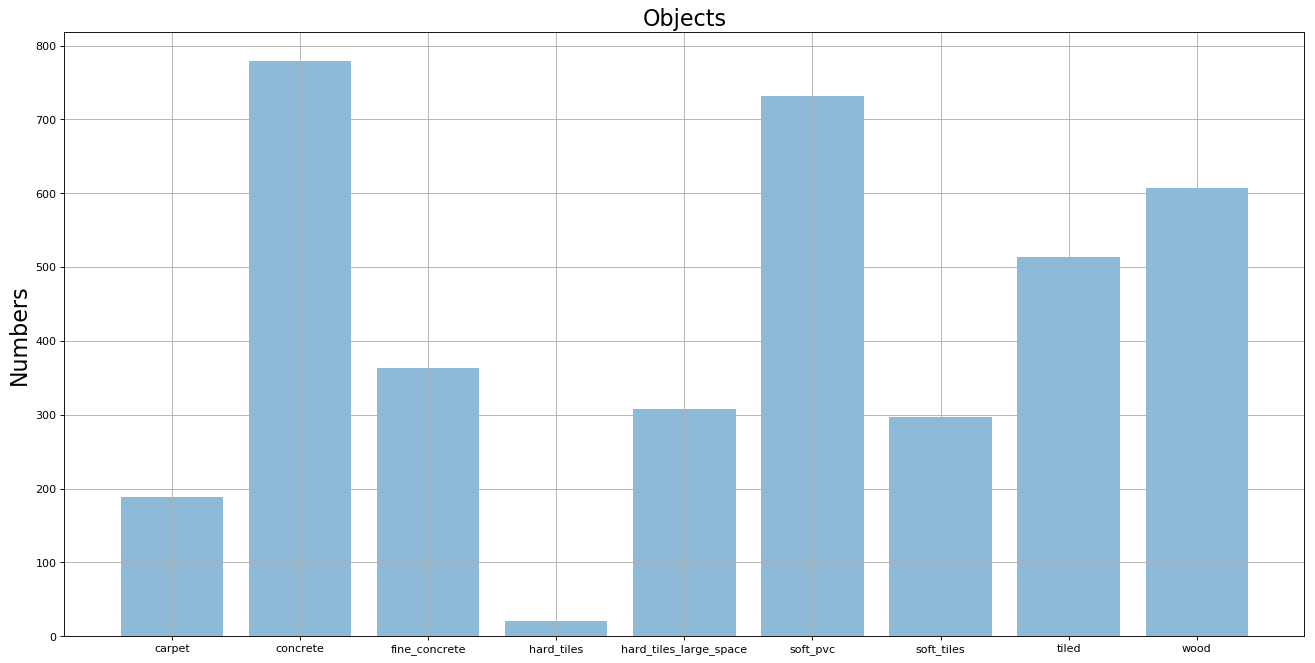

In [15]:
numbers = num_of_series(Y, n_classes)
objects = name_to_class.keys()
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(len(numbers)), numbers, align='center', alpha=0.5)
plt.xticks(np.arange(len(numbers)), objects)
plt.ylabel('Numbers', fontsize = 20)
plt.title('Objects', fontsize = 20)
plt.grid()
plt.show()

## 3. Preprocess the time series data

**Extract the features, output, and number of steps of the time series data**

In [16]:
features = X.columns.tolist()
features.remove("row_id")
features.remove("series_id")
features.remove("measurement_number")
output = "group_id"
n_steps = 128

**Create the feature of the abs value of linear acceleration**

In [17]:
X['linear_acceleration_abs'] = np.sqrt(X["linear_acceleration_X"]**2 + X["linear_acceleration_Y"]**2 + X["linear_acceleration_Z"]**2)
X_text['linear_acceleration_abs'] = np.sqrt(X_text["linear_acceleration_X"]**2 + X_text["linear_acceleration_Y"]**2 \
                                         + X_text["linear_acceleration_Z"]**2)
features.append("linear_acceleration_abs")

**Create the feature of abs value of angular velocity**

In [18]:
X['angular_velocity_abs'] = np.sqrt(X["angular_velocity_X"]**2 + X["angular_velocity_Y"]**2 + X["angular_velocity_Z"]**2)
X_text['angular_velocity_abs'] = np.sqrt(X_text["angular_velocity_X"]**2 + X_text["angular_velocity_Y"]**2 \
                                         + X_text["angular_velocity_Z"]**2)
features.append("angular_velocity_abs")

**Normalize featuers of train data**

In [19]:
X[features] = (X[features] - X[features].mean())/X[features].var()
X.head(10)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,linear_acceleration_abs,angular_velocity_abs
0,0_0,0,0,-1.574890,-1.414342,-10.448487,-9.391695,7.749525,1.172935,0.379938,-0.250876,-0.171067,-0.047964,-0.048125,-2.587543
1,0_1,0,1,-1.574890,-1.414322,-10.450268,-9.394452,4.879736,2.747035,0.429795,0.060206,-0.301332,-0.005918,-0.124291,-3.585311
2,0_2,0,2,-1.574890,-1.414342,-10.452049,-9.391695,0.511757,2.619230,0.251476,-0.112476,-0.282598,0.078828,-0.232634,-4.840186
3,0_3,0,3,-1.574868,-1.414362,-10.454721,-9.391695,-0.954013,1.412903,0.194437,0.085038,-0.390221,-0.090306,-0.022139,-4.993281
4,0_4,0,4,-1.574868,-1.414342,-10.454721,-9.390775,0.357463,-0.087223,0.465211,-0.182608,-0.309520,-0.132920,0.041746,-5.407997
5,0_5,0,5,-1.574890,-1.414421,-10.444035,-9.376067,4.289396,0.598385,0.113359,-0.164821,-0.413473,-0.128103,0.025871,-3.921859
6,0_6,0,6,-1.574890,-1.414461,-10.442254,-9.365955,5.910074,4.580434,0.313990,-0.077422,-0.469771,-0.007993,-0.137244,-3.036811
7,0_7,0,7,-1.574868,-1.414521,-10.441364,-9.358601,4.040915,3.792748,-0.071363,-0.071698,-0.613782,0.093390,-0.275830,-3.657711
8,0_8,0,8,-1.574847,-1.414541,-10.445816,-9.356763,-0.939087,3.899824,0.216201,0.420308,-0.452054,0.212734,-0.399713,-4.514316
9,0_9,0,9,-1.574847,-1.414501,-10.449378,-9.364117,-6.508348,2.411309,0.175452,0.098790,-0.431641,0.068292,-0.233149,-3.000604


**Normalize features of test data**

In [20]:
X_text[features] = (X_text[features] - X[features].mean())/X[features].var()
X_text.head(10)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,linear_acceleration_abs,angular_velocity_abs
0,0_0,0,0,-0.012118,-0.495887,-0.001662,0.000036,-0.000090,-0.000008,-0.001438,0.351419,19.263466,-44.883227,42.649357,0.000984
1,0_1,0,1,-0.012076,-0.495877,-0.001664,0.000037,-0.001580,0.000660,-0.003182,-2.480508,18.276043,-64.988749,55.106843,0.005376
2,0_2,0,2,-0.012045,-0.495872,-0.001665,0.000039,-0.001117,0.000903,-0.001952,5.098603,10.454968,-91.476322,71.202811,0.005066
3,0_3,0,3,-0.012021,-0.495877,-0.001664,0.000039,0.000972,0.000266,-0.001885,2.487751,8.510348,-98.989378,75.914043,0.002992
4,0_4,0,4,-0.012012,-0.495897,-0.001661,0.000038,0.002109,-0.000228,-0.000804,11.895690,12.769185,-84.279008,69.250201,0.005431
5,0_5,0,5,-0.012015,-0.495907,-0.001660,0.000037,0.001382,-0.000263,0.000015,2.306391,15.698024,-57.087086,48.215413,0.003670
6,0_6,0,6,-0.012007,-0.495902,-0.001660,0.000037,-0.000596,0.000028,-0.000716,7.352051,17.677909,-52.815654,48.203099,0.001579
7,0_7,0,7,-0.012020,-0.495897,-0.001661,0.000038,-0.001011,0.000069,0.001261,-0.879195,4.653624,-74.014132,56.389918,0.002697
8,0_8,0,8,-0.011995,-0.495912,-0.001659,0.000037,0.000260,-0.000292,0.001008,1.756745,7.395603,-81.356364,62.447361,0.001598
9,0_9,0,9,-0.012031,-0.495917,-0.001658,0.000037,0.000973,-0.000190,0.003081,4.070204,13.825307,-75.064179,60.178002,0.003302


## 4. Create class module of multilayer lstm model

**Create a function to generate batch of XY data**

In [21]:
def generate_batch(X, series, features, output, n_steps, n_classes, Y = None):
    """
    A function to generate batch of X and Y sequece
    """
    X_batch = np.zeros((len(series),n_steps,len(features)), dtype=np.float32)
    Y_batch = np.zeros((len(series), n_classes), dtype=np.float32)
    
    for n,id_ in enumerate(series):
        X_batch[n] = X[X['series_id'] == id_].sort_values("measurement_number")[features].values
        if Y is not None:
            Y_batch[n] = np.eye(n_classes)[Y[Y['series_id'] == id_]['label'].values]
        
    if Y is not None:
        return X_batch, Y_batch
    else:
        return X_batch

**Class module of multilayer lstm model**

In [22]:
class multilayer_lstm_model(object):
    """
    Multilayer lstm model
    """    
    def __init__(self, n_steps, n_inputs, n_outputs, n_layers, 
                 n_neurons, dense_layers, learning_rate, device, tf_seed, np_seed):
        """
        Class constuctor which intializes the parameters, placeholders, and operations of the model
        """        
        # parameters of lstm model
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.dense_layers = dense_layers
        self.learning_rate = learning_rate
        self.device = device
        self.tf_seed = tf_seed
        self.np_seed = np_seed    
        
        # placeholders and operations
        self.X = None
        self.Y = None
        self.keep_prob = None
        self.Y_ = None
        self.accuracy = None
        self.cost = None
        self.train_step = None
        
        # create model
        self.X, self.Y, self.keep_prob, \
        self.Y_, self.accuracy, self.cost, self.train_step = self.create_model()
        
        self.saver = None
        self.train_cost = None
        self.valid_cost = None
        self.valid_accuracy = None
        self.best_valid_accuracy = None
        self.best_iteration = None
        self.best_time = None
        self.log_of_computation_time = []
        
    def create_model(self):
        """
        A method to create the multilayer lstm model
        """
        # placeholder to store the input of the model
        X = tf.placeholder(tf.float32, [None, self.n_steps, self.n_inputs])
        # placeholder to store the output of the model
        Y = tf.placeholder(tf.float32, [None, self.n_outputs])
        # keep probability for dropout
        keep_prob = tf.placeholder(tf.float32)
        
        # n layer of lstm cells
        lstm_cells = [tf.nn.rnn_cell.LSTMCell(num_units=self.n_neurons) 
                      for layer in range(self.n_layers)]
        # dropout applied to layers of lstm
        lstm_cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
                           for cell in lstm_cells]
        # mount lstm cells on gpu
        cells_across_gpu = [tf.nn.rnn_cell.DeviceWrapper(cell,self.device) 
                            for cell in lstm_cells_drop]
        # create a multilayer layer lstm cell
        multi_cell = tf.nn.rnn_cell.MultiRNNCell(cells_across_gpu)
        # output and states of lstm
        outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
        # extract the top layer h state
        top_layer_h_state = states[-1][1]
        
        # iterate and create the dense layer
        for n, dense_layer in enumerate(self.dense_layers):
            # first dense layer (with dropout)
            if n == 0:
                with tf.device(self.device):
                    dense = tf.layers.dense(top_layer_h_state, dense_layer,
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            activation=tf.nn.elu)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
             # last dense layer (without dropout)
            elif n == len(self.dense_layers)-1:
                with tf.device(self.device):
                    dense = tf.layers.dense(dense, dense_layer,
                                            kernel_initializer=tf.variance_scaling_initializer())
            # middle dense layers (with droput)
            else:
                with tf.device(self.device):
                    dense = tf.layers.dense(dense, dense_layer, 
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            activation=tf.nn.elu)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
                    
        
        # compute predicted class
        Y_ = tf.argmax(dense, axis=1, output_type=tf.int32)
        # compute true class
        Y_true_cls = tf.argmax(Y, axis=1, output_type=tf.int32)
        # compute correct prediction
        correct_prediction = tf.equal(Y_, Y_true_cls)
        # compute accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # cost
        with tf.device(device):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=dense,labels=Y)
            cost = tf.reduce_mean(cross_entropy)

        # train step
        with tf.device(device):
            train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)        
        
        return X, Y, keep_prob, Y_, accuracy, cost, train_step
    
    
    def train_model(self, max_iter, batch_size, drop_prob, X, Y, series, 
                    train_indices, valid_indices, model_name, model_dir, generate_batch, *args):
        """
        A method to train the multilayer lstm model
        """        
        # generate sequences, length, & sentimentas for validation set
        X_valid, Y_valid = generate_batch(X, series[valid_indices], *args, Y=Y)
        # feed dict for validation
        feed_dict_validation =  {self.X:X_valid,
                                 self.Y:Y_valid,
                                 self.keep_prob: 1.0}
        # start time
        start_time = time.time()
        # create a saver object
        saver = tf.train.Saver(max_to_keep=1)
        # lists to store the train cost, validation cost, and validation accuracy
        train_cost = []
        valid_cost = []
        valid_accuracy = []
        # variables to store the best roc and best iteration
        # and the time to reach the best roc
        best_valid_accuracy = 0
        best_iteration = None
        best_time = None
        # path of model saver object
        model_path = model_dir+model_name
        # number of training data
        N = len(train_indices)
        # number of complete batches
        num_complete_mini_batches = math.floor(N/batch_size)
        
        # create a graph session and optimize the network under it
        with tf.Session() as sess:
        
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            
            # create an object of progress bar
            bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
                '[',progressbar.Percentage(),']',
                progressbar.Bar(),
                '(',progressbar.DynamicMessage("train_cost"),')',
                '(',progressbar.DynamicMessage("valid_cost"),')',
                '(',progressbar.DynamicMessage("valid_accuracy"),')',
                '(',progressbar.DynamicMessage("best_valid_accuracy"),')',
                '(',progressbar.DynamicMessage("time_elapsed"),'mins)'
            ])
            # start the progress bar
            bar.start()
            # counter variable to track the number of iterations
            counter = 0
            # iterate until maximum number of iterations is reached
            while True:
                # break out of the inner for loop if maximum number of iterations is reached
                if counter>=max_iter:
                    break
                # batch number
                k = counter%(num_complete_mini_batches+1)
                # if the mini batch is a complete batch
                if k < num_complete_mini_batches:
                    batch_indices = np.array(list(range(k * batch_size, k * batch_size + batch_size)))
                # handling the end case when the last mini batch is less than the batch_size
                elif N % batch_size != 0:
                    batch_indices = np.array(list(range(num_complete_mini_batches * batch_size, N)))
                
                # generate sequences, length, & sentimentas for validation set
                X_batch, Y_batch = generate_batch(X, series[batch_indices], *args, Y=Y)
                # feed dict for validation
                feed_dict_batch =  {self.X:X_batch,
                                    self.Y:Y_batch,
                                    self.keep_prob: drop_prob} 
                # execute optimization step
                sess.run(self.train_step, feed_dict=feed_dict_batch)
                # calculate temporary train cost and append it to the designated list
                temp_train_cost = self.cost.eval(session=sess, feed_dict=feed_dict_batch)
                train_cost.append(temp_train_cost)
                # calculate temporary validation cost and append it to the designated list
                temp_valid_cost = self.cost.eval(session=sess, feed_dict=feed_dict_validation)
                valid_cost.append(temp_valid_cost)
                # calculate temporary validation cost and append it to the designated list
                temp_valid_acc = self.accuracy.eval(session=sess, feed_dict=feed_dict_validation)
                valid_accuracy.append(temp_valid_acc)
                # compute running time from start point
                time_diff = (time.time()-start_time)/60
                # append elapsed time to the designated list
                self.log_of_computation_time.append(time_diff)
                # if valid cost is better than best recorded so far then
                # update the parameters of the best model and save the model
                if temp_valid_acc > best_valid_accuracy:
                    best_time = time_diff
                    best_valid_accuracy = temp_valid_acc
                    best_iteration = counter+1
                    saver.save(sess, model_path, global_step = best_iteration)
                    
                # store the required variables, placeholders and operations in designated class fields
                self.saver = saver
                self.train_cost = train_cost
                self.valid_cost = valid_cost
                self.best_valid_accuracy = best_valid_accuracy
                self.valid_accuracy = valid_accuracy
                self.best_iteration = best_iteration
                self.best_time = best_time

                # update the progress bar
                bar.update(counter+1, train_cost = temp_train_cost, 
                           valid_cost = temp_valid_cost,
                           valid_accuracy = temp_valid_acc, 
                           best_valid_accuracy = best_valid_accuracy, 
                           time_elapsed = time_diff)
                # increment counter variable
                counter += 1

            # finish the progress bar
            bar.finish()
            
    def create_predictions(self, model_path, X_test, series_test, class_to_name, 
                           n_folds, submission_dir, submission_file, generate_batch, *args):
        '''
        A function to compute predictions and submission file
        '''
        # submission path
        submission_path = submission_dir + submission_file

        with tf.Session() as sess: 
            # set random seed of tensorflow
            tf.set_random_seed(self.tf_seed)
            # restore the best model
            self.saver.restore(sess, model_path)
            # array to store the prediction
            preds = np.array([])
            # create a progress bar object
            bar = progressbar.ProgressBar(maxval=n_folds, widgets=[
                            '[',progressbar.Percentage(),']',
                            progressbar.Bar(),
                            '(',progressbar.DynamicMessage("number_of_folds_completed"),')'
                        ])            
            # start progress bat
            bar.start()
            
            N = X_test.shape[0]
            step = N//n_folds
            preds = np.array([])
            
            # iterate through each fold
            for i in range(n_folds):
                # start and end indices of the fold
                start = (step*i)
                end = (step*(i+1)) 
                # generate XY batch for test set
                X_batch = generate_batch(X_text, series_test[start:end], *args, Y=None)
                # feed dict for validation
                feed_dict_test =  {self.X:X_batch,
                                   self.keep_prob: 1.0} 
                # evaluate predictions of the fold
                fold_preds = self.Y_.eval(session=sess, feed_dict = feed_dict_test)
                # append it to designated array
                preds = np.append(preds, fold_preds)                    
                # update the progress bar
                bar.update(i+1, number_of_folds_completed = i+1)                
            # finish the progress bar
            bar.finish()

        submission = pd.DataFrame({"series_id": series_test, "preds": preds})
        submission['surface'] = submission["preds"].apply(lambda x: class_to_name[int(x)]) 
        submission[["series_id", "surface"]].to_csv(submission_path, header = True, index=False)

## 5. Create multilayer lstm model graph

**Inspect the devices of kernel**

In [23]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15475104692099934105
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 879191475964347931
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


**Set the device to gpu if available**

In [24]:
if len(devices)>1:
    device = devices[-1].name
else:
    device = devices[0].name

**Create graph**

In [25]:
n_layers = 2
n_neurons = 512
n_steps = 128 
n_inputs = len(features)
n_outputs = n_classes
dense_layers = [2*n_outputs,n_outputs]
learning_rate = (1e-4)*1
tf.reset_default_graph()
sequence_model = multilayer_lstm_model(n_steps, n_inputs, n_outputs, n_layers, 
                                       n_neurons, dense_layers, learning_rate,
                                       device, tf_rand_seed, np_rand_seed)

## 6. Train model

**Randomly generate train and validation indices**

In [26]:
train_indices = np.random.choice(n_series, round(n_series*0.8688), replace=False)
valid_indices = np.array(list(set(range(n_series)) - set(train_indices)))
print("Size of train set:", len(train_indices))
print("Size of validation set:", len(valid_indices))

Size of train set: 3310
Size of validation set: 500


**Train model**

In [27]:
max_iter = 600
batch_size = 500
keep_prob = 0.50
# name of model
model_name = 'multilayered_lstm_model'
model_dir = "./model_files/"
args =(features, output, n_steps, n_classes)
sequence_model.train_model(max_iter, batch_size, keep_prob, X, Y, series_train,
                           train_indices, valid_indices, model_name, model_dir,
                           generate_batch, *args)

[100%]||(train_cost:  0.795)(valid_cost:   1.36)(valid_accuracy:  0.584)(best_valid_accuracy:   0.67)(time_elapsed:   20.8mins)


**Plot of cost vs iterations**

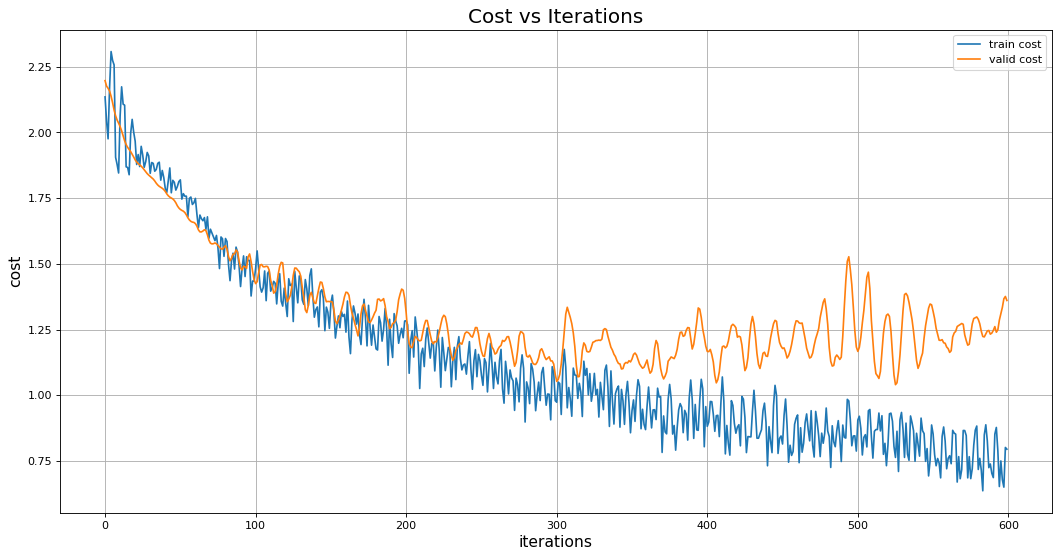

In [28]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sequence_model.train_cost, label = 'train cost')
plt.plot(sequence_model.valid_cost, label = 'valid cost')
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('cost', fontsize = 14)
plt.title("Cost vs Iterations",fontsize = 18)
plt.legend()
plt.grid()
plt.show()

**Plot of accuracy vs iterations**

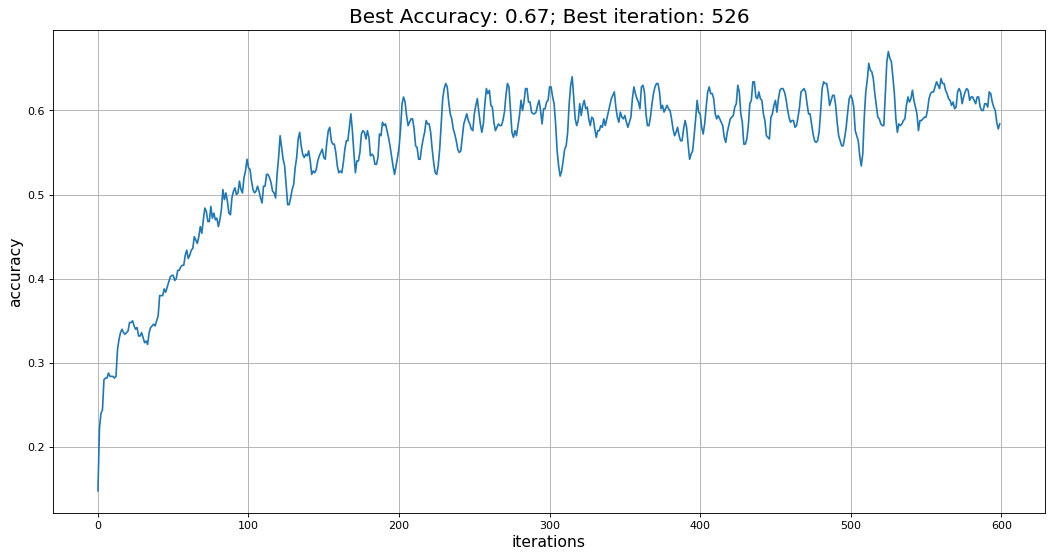

In [29]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sequence_model.valid_accuracy)
plt.title("Accuracy vs Iterations")
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('accuracy', fontsize = 14)
plt.title("Best Accuracy: "+str(sequence_model.best_valid_accuracy)+ \
          "; Best iteration: "+str(sequence_model.best_iteration),fontsize = 18)
plt.grid()
plt.show()

## 7. Create submission file

In [30]:
series_test = sorted(list(set(X_text['series_id'].values)))
print("Number of test series:",len(series_test))

Number of test series: 3816


In [31]:
model_path = model_dir+model_name+"-"+str(sequence_model.best_iteration) 
n_folds = 10
submission_dir = "./submission_dir/"
submission_file = "submission.csv"
sequence_model.create_predictions(model_path, X_text, series_test, class_to_name,
                                  n_folds, submission_dir, submission_file,
                                  generate_batch, *args)

INFO:tensorflow:Restoring parameters from ./model_files/multilayered_lstm_model-526


[100%]|####################################|(number_of_folds_completed:     10)
